## Making the trianable ansatz

In [1]:
import numpy as np
from scipy.optimize import minimize
import pennylane as qml

I = np.eye(2)
n_qubits = 6
size_of_vec = 2**n_qubits
num_layers = 5

from utils import DFS
inputStates, expectedStates = DFS().getInitialTargetStates()

In [15]:
def get_optimal_half_matrix(num_layers, addHalf=False):
    import numpy as np
    from scipy.optimize import minimize


    from utils import MatrixUtils
    matrixUtils = MatrixUtils()
    # Define the correct operations you want the matrix to perform on basis vectors
    def target_operations(parameters, inputStates):
        # Reshape the parameters into the matrix form
        normalParams = parameters[:num_layers*5]
        halfParams = parameters[num_layers*5:] if addHalf else None

        parameters = np.reshape(normalParams, (num_layers, 5))
        matrix = matrixUtils.get_total_matrix(size_of_vec=2**6, weights=parameters, halfWeights=halfParams)

        # Perform matrix multiplication with basis vectors
        results = []
        for i in range(len(inputStates)):
            results.append(np.matmul(matrix, inputStates[i]))

        # Define the target operations you want (modify this based on your specific task)
        target_result = np.array(expectedStates)

        # Calculate the loss as the difference between the obtained result and the target result
        # loss = square_loss(target_result, results)
        loss = matrixUtils.f_cnot_loss(target_result, results)
        return loss

    # Generate random basis vectors and target result
    basis_vectors = np.array(inputStates)
    target_result = np.array(expectedStates)

    # Flatten the matrix parameters for optimization
    initial_parameters = np.ndarray.flatten(matrixUtils.get_random_weights(num_layers))

    initial_parameters = np.concatenate((initial_parameters, matrixUtils.get_random_half_layer_weights())) if addHalf else initial_parameters

    # Use scipy's minimize function to optimize the parameters
    result = minimize(target_operations, initial_parameters, args=(basis_vectors,), method='L-BFGS-B')

    firstHalf, secondHalf = result.x[:num_layers*5], result.x[num_layers*5:] if addHalf else None
    # Reshape the optimized parameters back into the matrix form
    optimized_matrix = matrixUtils.get_total_matrix(size_of_vec=2**6, weights=firstHalf.reshape((num_layers, 5)), halfWeights=secondHalf)

    # print("Optimized Matrix:")
    # print(optimized_matrix)
    total_layers = num_layers + 0.5 if addHalf else num_layers

    predStates = [np.matmul(optimized_matrix, mat) for mat in inputStates]
    fcnot_loss = matrixUtils.f_cnot_loss(expectedStates, predStates)
    # print(f"f_cnot_loss for {total_layers} layers = {fcnot_loss}")
    # print(f"square_loss for {total_layers} layers = {matrixUtils.square_loss(expectedStates, predStates)}")
    return optimized_matrix, result.x, fcnot_loss

In [16]:
import os
import math

def make_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)


layers_arr = []
f_loss_arr = []
params_arr = []
magnitudes = []
for layers in range(3, 12, 1):
    for addHalf in [False, True]:
        l = layers + 0.5 if addHalf else layers
        currentPath = os.getcwd()
        directory = os.path.join(currentPath, f'trained_models/layers_{l}')
        make_dir_if_not_exists(directory)
        layers_arr.append([])
        f_loss_arr.append([])
        params_arr.append([])
        magnitudes.append([])
        for i in range(1,21,1):
            layers_arr[-1].append(l)
            m, p, f_loss = get_optimal_half_matrix(num_layers=layers, addHalf=addHalf)
            f_loss_arr[-1].append(f_loss)
            params_arr[-1].append(p)
            path = os.path.join(directory, f'model_{i}.txt')
            np.save(path, m)
            magnitude = math.floor(math.log10(f_loss))
            magnitudes[-1].append(magnitude)
            print(f"Trained model with layers: {l}, itertation: {i}, fcnot_loss: {f_loss}")

Trained model with layers: 3, itertation: 1, fcnot_loss: 1.0745380149674383e-07
Trained model with layers: 3, itertation: 2, fcnot_loss: 0.31138335934926215
Trained model with layers: 3, itertation: 3, fcnot_loss: 5.5755039852469285e-08
Trained model with layers: 3, itertation: 4, fcnot_loss: 4.8801246035156886e-06
Trained model with layers: 3, itertation: 5, fcnot_loss: 1.3818768405162847e-07
Trained model with layers: 3, itertation: 6, fcnot_loss: 6.989264130329236e-08
Trained model with layers: 3, itertation: 7, fcnot_loss: 0.3108295966931766
Trained model with layers: 3, itertation: 8, fcnot_loss: 4.470348358154297e-08
Trained model with layers: 3, itertation: 9, fcnot_loss: 0.32099550455774634
Trained model with layers: 3, itertation: 10, fcnot_loss: 0.22960900937847328
Trained model with layers: 3, itertation: 11, fcnot_loss: 6.363162241219334e-07
Trained model with layers: 3, itertation: 12, fcnot_loss: 0.30939020319424504
Trained model with layers: 3, itertation: 13, fcnot_loss

/Users/danielmolina/Documents/GitFolder/EE514-final-project/basic_neural_networks/utils.py:91: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1 - (1/4)*abs(loss))


ValueError: math domain error

In [17]:
import os
import math

layers = 11
for addHalf in [False, True]:
    l = layers + 0.5 if addHalf else layers
    currentPath = os.getcwd()
    directory = os.path.join(currentPath, f'trained_models/layers_{l}')
    make_dir_if_not_exists(directory)
    layers_arr.append([])
    f_loss_arr.append([])
    params_arr.append([])
    magnitudes.append([])
    for i in range(1,21,1):
        layers_arr[-1].append(l)
        m, p, f_loss = get_optimal_half_matrix(num_layers=layers, addHalf=addHalf)
        f_loss_arr[-1].append(f_loss)
        params_arr[-1].append(p)
        path = os.path.join(directory, f'model_{i}.txt')
        np.save(path, m)
        magnitude = math.floor(math.log10(f_loss)) if f_loss != 0 else -100
        magnitudes[-1].append(magnitude)
        print(f"Trained model with layers: {l}, itertation: {i}, fcnot_loss: {f_loss}")

Trained model with layers: 11, itertation: 1, fcnot_loss: 1.0848209096909341e-07
Trained model with layers: 11, itertation: 2, fcnot_loss: 7.670842216154189e-08
Trained model with layers: 11, itertation: 3, fcnot_loss: 6.495265578539184e-08
Trained model with layers: 11, itertation: 4, fcnot_loss: 9.424321830774485e-08
Trained model with layers: 11, itertation: 5, fcnot_loss: 7.742870483855355e-08
Trained model with layers: 11, itertation: 6, fcnot_loss: 9.599401598218922e-08
Trained model with layers: 11, itertation: 7, fcnot_loss: 4.712160915387242e-08
Trained model with layers: 11, itertation: 8, fcnot_loss: 7.300048299977713e-08
Trained model with layers: 11, itertation: 9, fcnot_loss: 6.314998895054189e-07
Trained model with layers: 11, itertation: 10, fcnot_loss: 2.356080457693621e-08
Trained model with layers: 11, itertation: 11, fcnot_loss: 5.3726900748371916e-08
Trained model with layers: 11, itertation: 12, fcnot_loss: 4.9421560620597e-08
Trained model with layers: 11, iterta

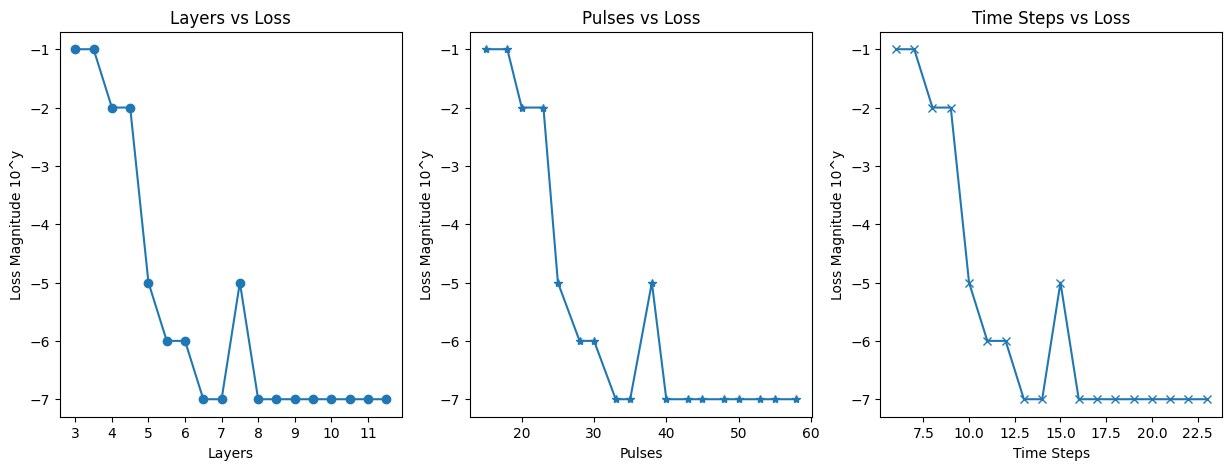

In [42]:

len(layers_arr), len(f_loss_arr), len(params_arr), len(magnitudes)

# pulses vs loss
# layers vs loss
# time steps vs loss
average_loss = []
layers = [layers_arr[i][0] for i in range(len(layers_arr))]
def get_number_of_pulses(layer):
    if int(math.floor(layer)) == layer:
        return layer * 5
    else:
        return (layer-0.5) * 5 + 3
def get_number_of_time_steps(layer):
    if int(math.floor(layer)) == layer:
        return layer * 2
    else:
        return (layer-0.5) * 2 + 1
pulses = [get_number_of_pulses(l) for l in layers]
time_steps = [get_number_of_time_steps(l) for l in layers]
for i in range(len(layers_arr)):
    # powers = [math.ceil(math.log10(f_loss)) for f_loss in f_loss_arr[i]]
    avg_loss = np.mean(f_loss_arr[i])
    magnitude = round(math.log10(avg_loss))
    average_loss.append(magnitude)
    # std_loss = np.std(f_loss_arr[i])

import matplotlib.pyplot as plt
import pandas as pd

data = {
    'layers': layers,
    'pulses': pulses,
    'time_steps': time_steps,
    'loss': average_loss
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(1,3, sharey=False, figsize=(15,5))


ax[0].plot(df['layers'], df['loss'], 'o-')
ax[0].set_xlabel('Layers')
ax[0].set_xticks(range(3, 12, 1))
ax[0].set_ylabel('Loss Magnitude 10^y')
ax[0].set_title('Layers vs Loss')

ax[1].plot(df['pulses'], df['loss'], '*-')
ax[1].set_xlabel('Pulses')
ax[1].set_ylabel('Loss Magnitude 10^y')
ax[1].set_title('Pulses vs Loss')

ax[2].plot(df['time_steps'], df['loss'], 'x-')
ax[2].set_xlabel('Time Steps')
ax[2].set_ylabel('Loss Magnitude 10^y')
ax[2].set_title('Time Steps vs Loss')

plt.show()


int

In [6]:
from utils import MatrixUtils
import math

mu = MatrixUtils()
predStates = [np.matmul(m1, mat) for mat in inputStates]
to = mu.f_cnot_loss(expectedStates, predStates)

print(to,po)

3.332000937312528e-08 -8


# Utilizing a minimization function suggested by ChatPGT and modified for our specific problem

In [12]:
def get_optimal_matrix(num_layers, half=False):
    import numpy as np
    from scipy.optimize import minimize


    from utils import MatrixUtils
    matrixUtils = MatrixUtils()
    # Define the correct operations you want the matrix to perform on basis vectors
    def target_operations(parameters, inputStates):
        # Reshape the parameters into the matrix form
        parameters = np.reshape(parameters, (num_layers+1 if half else num_layers, 5))
        matrix = matrixUtils.get_total_matrix(size_of_vec=2**6, weights=parameters)

        # Perform matrix multiplication with basis vectors
        results = []
        for i in range(len(inputStates)):
            results.append(np.matmul(matrix, inputStates[i]))

        # Define the target operations you want (modify this based on your specific task)
        target_result = np.array(expectedStates)

        # Calculate the loss as the difference between the obtained result and the target result
        # loss = square_loss(target_result, results)
        loss = matrixUtils.f_cnot_loss(target_result, results)
        return loss

    # Generate random basis vectors and target result
    basis_vectors = np.array(inputStates)
    target_result = np.array(expectedStates)

    # Flatten the matrix parameters for optimization
    initial_parameters = np.ndarray.flatten(matrixUtils.get_random_weights(num_layers))

    # Use scipy's minimize function to optimize the parameters
    result = minimize(target_operations, initial_parameters, args=(basis_vectors,), method='L-BFGS-B')

    # Reshape the optimized parameters back into the matrix form
    optimized_matrix = matrixUtils.get_total_matrix(size_of_vec=2**6, weights=result.x.reshape((num_layers, 5)))

    # print("Optimized Matrix:")
    # print(optimized_matrix)

    predStates = [np.matmul(optimized_matrix, mat) for mat in inputStates]
    print(f"f_cnot_loss for {num_layers} layers = {matrixUtils.f_cnot_loss(expectedStates, predStates)}")
    print(f"square_loss for {num_layers} layers = {matrixUtils.square_loss(expectedStates, predStates)}")
    return optimized_matrix, result.x

In [13]:
import pennylane as qml

matrix1, params1 = get_optimal_matrix(num_layers=8)
matrix2, params2 = get_optimal_matrix(num_layers=12)

f_cnot_loss for 8 layers = 1.4675941767984784e-07
square_loss for 8 layers = 2.9009743491920505e-28
f_cnot_loss for 12 layers = 2.1073424255447017e-08
square_loss for 12 layers = 1.6640034719505718e-31


In [14]:
flat = lambda mat : np.ndarray.flatten(mat)
amp_sqrd = lambda a : np.conjugate(a)*a

print(f'params1={params1}')
print(f'params2={params2}')

temp = np.matmul(matrix1, np.conjugate(np.transpose(matrix2)))
target = np.eye(temp.shape[0])


def mean_squared_error_complex(a1,a2):
    n = len(a1)
    t = 0
    for i in range(n):
        t += amp_sqrd(a1[i] - a2[i])
    return np.real(t/n)

mse = mean_squared_error_complex(flat(temp), flat(target))

print(f'MSE={mse}')

params1=[-0.53776279  0.01087519 -0.97064673 -0.41250992  0.06527786 -0.6740068
  0.46309053  0.46493861  0.86789249  0.24952521 -0.00817814 -0.58525397
 -0.49847904  0.26401364  0.58901837  0.47484948 -0.51859519  0.48456201
  0.96868777 -0.75722557 -0.35263081  1.12137384  0.01643639 -0.26469552
 -0.51133436  0.02086598 -0.5129765  -0.91082416 -0.72381358  0.70035167
 -0.83228161  0.30341447  0.20024559 -0.12199987  0.69083451 -0.76650945
  0.10490144  0.33381965  0.03346551  0.46261457]
params2=[-0.89640595  0.44511122 -0.07451297  0.22047689  1.05412178 -0.13885729
  0.62525218  0.74385162  0.76362229  0.84292     0.40638121  0.70929019
  0.60906231 -0.92276944  0.61712147  0.38767971  0.70527334 -0.5893029
  0.59438139  0.89513418  0.16828765  0.82446941  0.90477795  0.13986333
 -0.42391503 -0.50445723 -0.67671051 -0.35620053  0.42677777 -0.78969741
 -0.91291488  0.23733852  0.17391615 -0.46338381 -0.14638486  0.91769235
  0.05951    -0.09475124  0.62889173 -0.40302423 -1.0413838 

# Attempted to make a Neural Network model but wasn't working

In [41]:
import tensorflow as tf
import numpy as np

def f_cnot_loss(y_true, y_pred):
    loss = 0
    for i in range(np.size(y_true)//(2**n_qubits)):
        fidelity = qml.math.fidelity_statevector(y_true[i], y_pred[i])
        loss += fidelity
    return np.sqrt(1 - (1/4)*abs(loss))

from utils import MatrixUtils
matrixUtils = MatrixUtils()

# Define the correct operations you want the matrix to perform on basis vectors
def target_operations(parameters, inputVectors):
    # Perform matrix multiplication with basis vectors
    # Reshape the parameters into the matrix form
    params = np.reshape(parameters, (num_layers, 5))
    matrix = tf.constant(matrixUtils.get_total_matrix(2**6, params), dtype=tf.complex128)
    # results = tf.matmul(matrix, inputVectors, transpose_b=True)
    results = []
    for i in range(np.size(inputVectors)//(2**n_qubits)):
        results.append(np.matmul(matrix, inputVectors[i]))
    results = tf.constant(results, dtype=tf.complex128)

    # Define the target operations you want (modify this based on your specific task)
    target_results = tf.constant(expectedStates, dtype=tf.complex128)

    # Calculate the loss as the mean squared error between the obtained result and the target result
    loss = f_cnot_loss(target_results, results)
    return loss

# Example: Set the number of basis vectors and their dimensionality
num_vectors = 4
vector_dimension = 2**n_qubits

# Generate random basis vectors and target result
inputVectors = tf.constant(inputStates, dtype=tf.complex128)

# Define the matrix as a TensorFlow Variable
parameters = tf.Variable(np.ndarray.flatten(matrixUtils.get_random_weights(num_layers)), dtype=tf.float32)

# Use an optimizer to minimize the loss
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = tf.constant(target_operations(parameters, inputVectors))

    gradients = tape.gradient(loss, [parameters])
    optimizer.apply_gradients(zip(gradients, [parameters]))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Get the optimized matrix
parameters = np.reshape(parameters, (num_layers, 5))
matrix = matrixUtils.get_total_matrix(2**6,parameters)
optimized_matrix = matrix.numpy()

print("Optimized Matrix:")
print(optimized_matrix)

ValueError: No gradients provided for any variable: (['Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=(35,) dtype=float32, numpy=
array([ 2.5269053 ,  0.5212329 ,  0.9739547 ,  2.5969772 ,  0.6503308 ,
        2.1297295 , -1.931953  ,  0.7041187 , -1.3276408 , -2.2411902 ,
        1.2720861 ,  1.5847887 ,  3.0150158 ,  1.2192807 , -1.7325749 ,
       -0.82495993, -1.756478  , -1.1077476 , -2.713036  ,  1.8335059 ,
        1.614816  ,  2.2740006 ,  2.2506728 , -1.1599189 , -2.0895307 ,
        3.0720863 , -0.31033638, -0.30215982, -2.318698  , -3.134845  ,
       -1.3226986 , -2.8566093 ,  1.5320274 ,  0.39243674,  0.13296835],
      dtype=float32)>),).

# Manual matrix multiplication of what the paper suggested

In [7]:
p1 = np.arccos(-1/np.sqrt(3))/np.pi
p2 = np.arcsin(1/3)/np.pi


def Id_n(n):
    assert n >= 0
    if n==0:
        return 1
    temp = I
    for i in range(n-1):
        temp = np.kron(temp, I)
    return temp

matrixUtils = MatrixUtils()
U_ex = lambda p : matrixUtils.U_ex(p, scale=np.pi)


bounds = [[3,4],[2,5],[3,4],[2,5],[1,4],[2,5],[1,4],[2,5],[1,4],[2,5],[3,4],[2,5],[3,4]]
operators = [matrixUtils.U_ex(p1, scale=np.pi),
np.kron(U_ex(1/2),U_ex(p2)),
U_ex(1),
np.kron(U_ex(-1/2),U_ex(-1/2)),
np.kron(U_ex(1),U_ex(-1/2)),
np.kron(U_ex(-1/2),U_ex(1)),
np.kron(U_ex(-1/2),U_ex(1/2)),
np.kron(U_ex(-1/2),U_ex(1)),
np.kron(U_ex(1),U_ex(-1/2)),
np.kron(U_ex(-1/2),U_ex(-1/2)),
U_ex(1),
np.kron(U_ex(1/2),U_ex(1-p2)),
U_ex(-p1)]


newOps = []
for i, (start, end) in enumerate(bounds):
    temp = matrixUtils.nestedKron(Id_n(start),operators[i], Id_n(5-end))
    newOps.append(temp.copy())

totalOperator = np.eye(2**6)
for op in newOps:
    totalOperator = np.matmul(op,totalOperator)

U_cnot = totalOperator.copy()

def f_cnot_loss(y_true, y_pred):
    loss = 0
    for i in range(np.size(y_true)//(2**n_qubits)):
        fidelity = qml.math.fidelity_statevector(y_true[i], y_pred[i])
        loss += fidelity
    return np.sqrt(1 - (1/4)*abs(loss))


predStates = [np.matmul(U_cnot, mat) for mat in inputStates]
print(f"f_cnot loss = {f_cnot_loss(expectedStates, predStates)}")

f_cnot loss = 0.7189360747413388
